In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns 
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import datetime as dt
import random
import os 
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, GRU,LSTM, Dense,Lambda,Conv1D



BATCH_SIZE = 128
PATIENCE = 20
MAX_EPOCH = 100
TRAIN_STEPS = 1 * 168
PREDICT_STEPS = 24
WINDOW_SIZE = TRAIN_STEPS + PREDICT_STEPS 

LSTM_DIM = 128
INPUT_FEATURES = 10
OUTPUT_FEATURES = 1
filters = 16
krnl_sz = 2
DECOD_DENSE = 24




In [2]:
FILE_DIR = 'C:\\Users\\Zain Ahmed\\Desktop\\Literature review\\Project Folder\\Data.xlsx'


# Loading the data from execl file

In [3]:
data = pd.read_excel(FILE_DIR)

# Keeping DATE,Time and Load Columns Only 
# Also keeping daily hours between 0-23

In [4]:
data['Time']=data['Time'].astype(int)-1

In [5]:
data.columns

Index(['dayodweek', 'workday dinary', 'workday', 'Weekday', 'DATE', 'Time',
       ' Load(KW)   ', ' KVAR  ', 'KVA', 'P/F', 'pload', 'pkvar', 'pkva',
       'ppf', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)',
       'Wind Dir (10s deg)', 'Wind Spd (km/h)', 'Visibility (km)',
       'Stn Press (kPa)', 'Wind Chill'],
      dtype='object')

In [6]:
#data = data.loc[:,('DATE','Time',' Load(KW)   ')]
#DROPPING WIND CHILL DUE TO HIGH NANs
data = data.loc[:,('DATE','Time',' Load(KW)   ','Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)','Visibility (km)','Stn Press (kPa)')]

# Concatenate Date and Time

In [7]:
data['datetime'] = data['DATE'].astype('str') + '-' + data['Time'].astype('str')

In [8]:
data['datetime']=pd.to_datetime(data['datetime'],format='%Y-%m-%d-%H')
data['is_weekday'] = (data['datetime'].dt.weekday<=5).astype('int')
data['month'] = (data['datetime']).dt.month

In [9]:
data = data.set_index('datetime')

In [10]:
data = data.drop(columns=['DATE','Time'])

In [11]:
data.columns

Index([' Load(KW)   ', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)',
       'Wind Dir (10s deg)', 'Wind Spd (km/h)', 'Visibility (km)',
       'Stn Press (kPa)', 'is_weekday', 'month'],
      dtype='object')

# We will ensure the continuity of the data

In [12]:
num_of_bre = (data.asfreq(freq='1H').shape[0]) - (data.shape[0])
percen = ((num_of_bre)/data.shape[0])*100
print('The number of breaks in the data are {} which is {:0.2} percent of the total data'.format(num_of_bre,percen))

The number of breaks in the data are 3 which is 0.0081 percent of the total data


# Make the data continous 

In [13]:
data.head()

,Load(KW),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),is_weekday,month
datetime,,,,,,,,,,
2016-01-02 00:00:00,10809,-3.7,-6.5,81.0,29.0,30.0,24.1,98.09,1,1
2016-01-02 01:00:00,10890,-3.9,-6.9,80.0,28.0,32.0,24.1,98.09,1,1
2016-01-02 02:00:00,10803,-4.1,-7.2,79.0,29.0,27.0,24.1,98.15,1,1
2016-01-02 03:00:00,10839,-4.0,-7.1,79.0,28.0,34.0,24.1,98.13,1,1
2016-01-02 04:00:00,10812,-4.3,-7.3,80.0,29.0,25.0,24.1,98.16,1,1


In [14]:
data = data.asfreq(freq='1H')

<AxesSubplot:xlabel='datetime'>

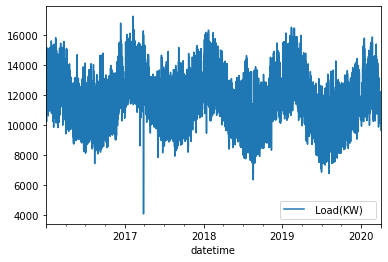

In [15]:
data.plot(y=' Load(KW)   ')

In [16]:
data.shape

(37224, 10)

# Dividing our data in train, validation and test sets 

In [17]:
tr_id = int((data.shape[0]*0.75)/24)*24
val_id = int((data.shape[0]*0.90)/24)*24
tra_data = data.iloc[:tr_id,:]
val_data = data.iloc[tr_id:val_id,:]
tes_data = data.iloc[val_id:,:]

# Now we will write the proprocessing function

In [18]:
def pre_process(sample):
    '''
    Takes a dataframe and 
            
    - replaces NA values by forward filling
    
    '''
    ## Use the below line of code to sample data based on hours 
    ##sample = sample[(sample.index.dayofweek<5) & ((of_da_fi.index.hour>4) & (of_da_fi.index.hour<19))]
    
    #using forward filling method to fill the missing data 
        
    sample = sample.fillna(method='ffill')
    
    ## This line of code checks for NA values 
    
    check_na = int(sample.isnull().sum().sum())
    
    print('There are {} NA values in the dataframe'.format(check_na))
    
    #plt.figure(figsize=(3,3))
    
    #sns.violinplot(data=sample)
    
    #plt.xticks(rotation=90)
        
    return sample

In [19]:
train_data = pre_process(tra_data)


There are 0 NA values in the dataframe


In [20]:
vali_data = pre_process(val_data)


There are 0 NA values in the dataframe


In [21]:
test_data = pre_process(tes_data)

There are 0 NA values in the dataframe


In [22]:
tes_data.fillna(method='ffill').isnull().sum()

 Load(KW)              0
Temp (°C)              0
Dew Point Temp (°C)    0
Rel Hum (%)            0
Wind Dir (10s deg)     0
Wind Spd (km/h)        0
Visibility (km)        0
Stn Press (kPa)        0
is_weekday             0
month                  0
dtype: int64

In [23]:
tes_data.shape

(3744, 10)

# Rolling window function for 1D data

In [24]:
def rolling_window(array_data,input_size,output_size,offset):
    '''
    The function takes a series array_data of size (size,) 

    and generates
    
    a array of size (input_size,((array_size-(input_size+output_size)/stride)+1)) as inputs 
    
    and array of size (array_size-(input_size+output_size)/stride)+1)as output 
    
    '''
        
    # Normalizing the dataset
        
    scaler = StandardScaler()
    
    scaler = scaler.fit(array_data)
    
    array_data = scaler.transform(array_data)
    
#     lab_data = array_data[:,0]
    
#     for i in range(input_size,len(array_data)-output_size+1,offset):
            
#             data.append(array_data[i-input_size:i,0:array_data.shape[1]])
    
#             labels.append(lab_data[i:i+output_size])

        
    data_idx = sliding_window_view(np.arange(array_data.shape[0]).reshape(-1),window_shape=input_size)[::offset][:-1]
    
    data = array_data[data_idx]

    labels = sliding_window_view(array_data[input_size:,0].reshape(-1),window_shape=output_size)[::offset]
    
    input_decoder = np.zeros((data.shape[0],1,LSTM_DIM+OUTPUT_FEATURES))

    
    assert data.shape[0] == labels.shape[0],"Training rows and labels are unequal"    
    
#    if output_size == offset:
        
#        ra_in = random.randint(0,data.shape[0]-2) 
        
#        a = data[ra_in+1,-offset:]
        
#        b = labels[ra_in]
        
#        np.alltrue(a == b)
    
#    data = np.expand_dims(data,axis=2)
    
#    labels = np.expand_dims(labels,axis=2)
    
#    data = np.array(data)
    
#    labels = np.array(labels)
        
    return data,labels,scaler,array_data,input_decoder

In [25]:
test_data

,Load(KW),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),is_weekday,month
datetime,,,,,,,,,,
2019-10-28 00:00:00,10152.0,3.6,2.5,92.0,36.0,23.0,24.1,99.83,1.0,10.0
2019-10-28 01:00:00,10092.0,3.7,3.0,95.0,36.0,18.0,16.1,99.85,1.0,10.0
2019-10-28 02:00:00,9960.0,4.0,3.5,96.0,35.0,20.0,16.1,99.88,1.0,10.0
2019-10-28 03:00:00,10008.0,3.4,2.8,96.0,36.0,30.0,8.1,99.88,1.0,10.0
2019-10-28 04:00:00,10296.0,2.8,2.2,96.0,36.0,29.0,8.1,99.92,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-31 19:00:00,10500.0,0.6,0.4,99.0,9.0,10.0,0.6,99.93,1.0,3.0
2020-03-31 20:00:00,10332.0,1.6,1.4,99.0,11.0,14.0,0.2,99.97,1.0,3.0
2020-03-31 21:00:00,9984.0,2.3,2.1,99.0,14.0,17.0,0.2,100.00,1.0,3.0


# Creating the rolling window for input size 168 and output window size of 24

In [26]:
tra_data_sli,tra_lab,tra_sca,tra_stan,tra_decod = rolling_window(train_data,input_size=TRAIN_STEPS,output_size=24,offset=24)
val_data_sli,val_lab,val_sca,val_stan,val_decod = rolling_window(vali_data,input_size=TRAIN_STEPS,output_size=24,offset=24)
tes_data_sli,tes_lab,test_scaler,tes_stan,tes_decod = rolling_window(test_data,input_size=TRAIN_STEPS,output_size=24,offset=24)

In [27]:
tra_data_sli.shape

(1156, 168, 10)

In [28]:
tra_lab.shape

(1156, 24)

# We will now focus on Seq2Seq Implementation

In [29]:
print("Number of training samples are {}".format(tra_data_sli.shape[0]))
print("Number of validation samples are {}".format(val_data_sli.shape[0]))
print("Number of test samples are {}".format(tes_data_sli.shape[0]))

Number of training samples are 1156
Number of validation samples are 225
Number of test samples are 149


In [30]:
tra_lab.shape

(1156, 24)

In [31]:
tra_data_sli.shape
#model_seq_to_seq_without_atten = keras.models.load_model('Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler_no_attention.h5') 
#predict_wout_attention = model_seq_to_seq_without_atten.predict(x=[tes_data_sli,tes_decod])


(1156, 168, 10)

In [32]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, verbose=0):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.verbose= verbose

    def call(self, query, values):
        if self.verbose:
            print('\n******* Bahdanau Attention STARTS******')
            print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
            print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        if self.verbose:
            print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        if self.verbose:
            print('score: (batch_size, max_length, 1) ',score.shape)
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        if self.verbose:
            print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        if self.verbose:
            print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        if self.verbose:
            print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
            print('\n******* Bahdanau Attention ENDS******')
        
        return context_vector, attention_weights

In [33]:


# input_timesteps = 168
# features = 8
# output_timesteps = 24
# lstm_dim = 256

# def encoder_decoder_model(batch_size):

#     encoder_inputs = Input(shape=(input_timesteps,features),name='encoder_inputs')
#     encoder_lstm = LSTM(lstm_dim,return_state=True,name='encoder_lstm')
#     encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

#     ###Input data is used by the encoder lstm and context vector is generated
    
#     states = [state_h,state_c]

#     ###Decoder network defination
#     decoder_inputs = Input(shape=(1, 1))
#     decoder_lstm = LSTM(lstm_dim,return_state=True,return_sequences=True,name='decoder_lstm')
#     decoder_dense = Dense(1,name='decoder_output')
    
#     all_outputs = []
    
#     attention= BahdanauAttention(lstm_dim, verbose=verbose)

#     inputs = decoder_inputs
    
#     for _ in range(output_timesteps):
        
#         context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
        
#         lstm_outputs , state_h , state_c = decoder_lstm(inputs,initial_state=states)
        
#         outputs = decoder_dense(lstm_outputs)
        
#         states = [state_h,state_c]
        
#         all_outputs.append(outputs)
        
#         inputs = outputs
        
#     decoder_outputs = all_outputs
    
#     model = Model([encoder_inputs,decoder_inputs],decoder_outputs,name='encoder_decoder_model')
    
#     model.compile(optimizer='adam',loss=tf.keras.losses.Huber(),metrics=["mean_squared_error"])
    
#     return model
    

In [34]:
print('****Model Hyperparameters****')

print('BATCH_SIZE : ',BATCH_SIZE)

print('LSTM_DIM : ',LSTM_DIM)

print('INPUT_FEATURES : ',INPUT_FEATURES)

print('OUTPUT_FEATURES : ',OUTPUT_FEATURES)

print('TRAIN_STEPS : ',TRAIN_STEPS)

print('PREDICT_STEPS : ',PREDICT_STEPS)


****Model Hyperparameters****
BATCH_SIZE :  128
LSTM_DIM :  128
INPUT_FEATURES :  10
OUTPUT_FEATURES :  1
TRAIN_STEPS :  168
PREDICT_STEPS :  24


In [35]:
def create_enc_dec_att_model(BATCH_SIZE):
    ## Enoder Model

    encoder_input = Input(shape = (TRAIN_STEPS,INPUT_FEATURES),name='encoder_input')
    
    conv_layer = Conv1D(filters=filters,kernel_size=krnl_sz)
    
    pool_layer = tf.keras.layers.MaxPool1D(2)
#    conv_flat_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())

    encoder_lstm = GRU(LSTM_DIM , return_sequences=True,return_state=True,name='encoder_lstm')
    
    one_d_conv = conv_layer(encoder_input)
    
    pool = pool_layer(one_d_conv)
#    conv_flat = conv_flat_layer(pool)

    encoder_output , en_h  = encoder_lstm(pool)

    encoder_states = [en_h]

    attention_layer = BahdanauAttention(LSTM_DIM)

    ## Decoder_Model

    decoder_input = Input(shape = (1 , OUTPUT_FEATURES+LSTM_DIM) , name='decoder_input')
    
    decoder_lstm_2 = GRU(LSTM_DIM, return_sequences=True, return_state = True, name = 'decoder_lstm_2')

    decoder_dense_1 = Dense(DECOD_DENSE,name='decoder_dense')
    
    decoder_output_layer = Dense(1,name='decoder_output')

    all_outputs = []

    ## Decoder input starting vector 

    inputs = np.zeros((BATCH_SIZE,1,OUTPUT_FEATURES),dtype=np.float32)

    ##for attention

    decoder_output = en_h

    states = encoder_states
    
    for _ in range(PREDICT_STEPS):

        context_vector , attention_weights = attention_layer(decoder_output,encoder_output)

    #    print("Context Vector Shape : ",context_vector.shape)

    #    print("Attention Weights : ",attention_weights.shape)

    #    print("Decoder Output Before Concat : ",decoder_output.shape)

#        context_vector = tf.expand_dims(context_vector,1)

    #    context_vector = tf.cast(context_vector,tf.float64)

    #    print("Reshaped Context Vector : ",context_vector.shape)

    #    print("Input Shape : ",inputs.shape)

#        inputs = tf.concat([context_vector,inputs],axis=-1)

    #    print("New Input Shape: ",inputs.shape)

#        x = decoder_lstm_1(decoder_input,initial_state=states)
        
        decoder_outputs, state_h  = decoder_lstm_2(decoder_input,initial_state=states)

        output = decoder_output_layer(decoder_outputs)
        
    #    print("Decoder Output : ",output.shape)

    #    output = tf.expand_dims(output,1)

        all_outputs.append(output)

        inputs = output

        states = [state_h]
        
    all_out = Lambda(lambda x: tf.keras.backend.concatenate(x, axis=1))(all_outputs)
    
    ##Flatten layer
    
    flat_layer = tf.keras.layers.Flatten()
    
    all_out = flat_layer(all_out)
        
    ###Defining Fullyy connected layer 
    
    fc_layer = Dense(128,name='FC_LAYER'
#                     ,kernel_regularizer=tf.keras.regularizers.L2(0.01)
                    )
    
    output_layer = Dense(24,name='output_layer')

    fc_layer_1 = fc_layer(all_out)
    
    final_output = output_layer(fc_layer_1)
    
    model = Model([encoder_input,decoder_input], final_output, name='model_encoder_decoder')

    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mean_squared_error'])

    return model




In [36]:
My_Model = create_enc_dec_att_model(BATCH_SIZE)

In [37]:
My_Model.summary()

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 168, 10)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 167, 16)      336         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 83, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 decoder_input (InputLayer)     [(None, 1, 129)]     0           []                               
                                                                              

                                                                  'decoder_lstm_2[20][0]',        
                                                                  'decoder_lstm_2[21][0]',        
                                                                  'decoder_lstm_2[22][0]',        
                                                                  'decoder_lstm_2[23][0]']        
                                                                                                  
 lambda (Lambda)                (None, 24, 1)        0           ['decoder_output[0][0]',         
                                                                  'decoder_output[1][0]',         
                                                                  'decoder_output[2][0]',         
                                                                  'decoder_output[3][0]',         
                                                                  'decoder_output[4][0]',         
          

In [38]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.5)

model_chk = tf.keras.callbacks.ModelCheckpoint(
            '1 Weekly Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler.h5',monitor="val_loss",mode='min',verbose=1,save_best_only=True
)

history = My_Model.fit(x=[tra_data_sli,tra_decod],y=tra_lab, epochs=MAX_EPOCH, batch_size=BATCH_SIZE,validation_data=([val_data_sli,val_decod], val_lab), verbose=1,callbacks=[model_chk])

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4096 - mean_squared_error: 0.9277
Epoch 1: val_loss improved from inf to 0.30302, saving model to 1 Weekly Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler.h5
10/10 [==============================] - 60s 1s/step - loss: 0.4088 - mean_squared_error: 0.9257 - val_loss: 0.3030 - val_mean_squared_error: 0.6705
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2644 - mean_squared_error: 0.5760
Epoch 2: val_loss improved from 0.30302 to 0.19729, saving model to 1 Weekly Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler.h5
10/10 [==============================] - 1s 133ms/step - loss: 0.2644 - mean_squared_error: 0.5760 - val_loss: 0.1973 - val_mean_squared_error: 0.4157
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.1592 - mean_squared_error: 0.3307
Epoch 3: val_loss improved from 0.19729 to 0.15346, saving model to 1 Weekly Seq2Se

Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 0.0720 - mean_squared_error: 0.1473
Epoch 24: val_loss improved from 0.10639 to 0.10223, saving model to 1 Weekly Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler.h5
10/10 [==============================] - 1s 132ms/step - loss: 0.0720 - mean_squared_error: 0.1473 - val_loss: 0.1022 - val_mean_squared_error: 0.2071
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 0.0689 - mean_squared_error: 0.1407
Epoch 25: val_loss did not improve from 0.10223
10/10 [==============================] - 1s 126ms/step - loss: 0.0689 - mean_squared_error: 0.1407 - val_loss: 0.1064 - val_mean_squared_error: 0.2170
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 0.0712 - mean_squared_error: 0.1450
Epoch 26: val_loss improved from 0.10223 to 0.09430, saving model to 1 Weekly Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler.h5
10/10 [=================

10/10 [==============================] - 1s 124ms/step - loss: 0.0502 - mean_squared_error: 0.1025 - val_loss: 0.0828 - val_mean_squared_error: 0.1673
Epoch 50/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0498 - mean_squared_error: 0.1016
Epoch 50: val_loss did not improve from 0.07972
10/10 [==============================] - 1s 123ms/step - loss: 0.0498 - mean_squared_error: 0.1015 - val_loss: 0.0908 - val_mean_squared_error: 0.1834
Epoch 51/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0501 - mean_squared_error: 0.1022
Epoch 51: val_loss did not improve from 0.07972
10/10 [==============================] - 1s 124ms/step - loss: 0.0501 - mean_squared_error: 0.1021 - val_loss: 0.0838 - val_mean_squared_error: 0.1687
Epoch 52/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0505 - mean_squared_error: 0.1030
Epoch 52: val_loss did not improve from 0.07972
10/10 [==============================] - 1s 123ms/step - loss: 0.0504 - mean_squared_

 9/10 [==========================>...] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.0867
Epoch 75: val_loss did not improve from 0.07415
10/10 [==============================] - 1s 122ms/step - loss: 0.0424 - mean_squared_error: 0.0866 - val_loss: 0.0767 - val_mean_squared_error: 0.1543
Epoch 76/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0438 - mean_squared_error: 0.0892
Epoch 76: val_loss did not improve from 0.07415
10/10 [==============================] - 1s 124ms/step - loss: 0.0437 - mean_squared_error: 0.0891 - val_loss: 0.0838 - val_mean_squared_error: 0.1691
Epoch 77/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0423 - mean_squared_error: 0.0865
Epoch 77: val_loss did not improve from 0.07415
10/10 [==============================] - 1s 124ms/step - loss: 0.0423 - mean_squared_error: 0.0864 - val_loss: 0.0947 - val_mean_squared_error: 0.1912
Epoch 78/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0412 - mean_squared_error:

In [39]:
predict = My_Model.predict(x=[tes_data_sli,tes_decod])

5/5 [==============================] - 10s 21ms/step


In [40]:
predict.shape

(149, 24)

In [45]:

predict.shape

(149, 24)

In [47]:
np.repeat(predict.flatten().reshape(-1,1),10,axis=1).shape

(3576, 10)

In [48]:
prediction = test_scaler.inverse_transform(np.repeat(predict.flatten().reshape(-1,1),10,axis=1))

In [49]:
grou_tru = test_scaler.inverse_transform(np.repeat(tes_lab.flatten().reshape(-1,1),10,axis=1))

In [50]:
print("The mean squared error is ", mean_squared_error(grou_tru[:,0],prediction[:,0]))
print("The mean abolsute error is ", mean_absolute_error(grou_tru[:,0],prediction[:,0]))

The mean squared error is  282324.99293149984
The mean abolsute error is  412.53251876660374


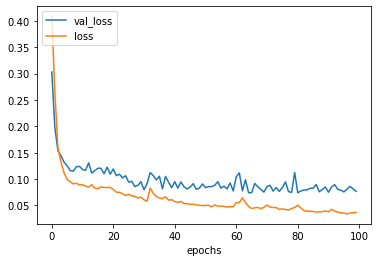

In [51]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.legend(['val_loss', 'loss'], loc='upper left')


In [53]:
model_seq_to_seq_with_atten = keras.models.load_model('1 Weekly Seq2Seq GRU FC Layer Implementation Old University Data Using Std Scaler.h5') 
predict_wout_attention = model_seq_to_seq_with_atten.predict(x=[tes_data_sli,tes_decod])


5/5 [==============================] - 11s 19ms/step


In [54]:
grou_tru = test_scaler.inverse_transform(np.repeat(tes_lab.flatten().reshape(-1,1),10,axis=1))
prediction_without_attention = test_scaler.inverse_transform(np.repeat(predict_wout_attention.flatten().reshape(-1,1),10,axis=1))


In [55]:
print(mean_squared_error(grou_tru[:,0],prediction_without_attention[:,0]))
print(mean_absolute_error(grou_tru[:,0],prediction_without_attention[:,0]))
#print((r2_score(grou_tru[:,0],prediction_without_attention[:,0])))

287450.0024865983
415.8421527085955


In [56]:
test_data

,Load(KW),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),is_weekday,month
datetime,,,,,,,,,,
2019-10-28 00:00:00,10152.0,3.6,2.5,92.0,36.0,23.0,24.1,99.83,1.0,10.0
2019-10-28 01:00:00,10092.0,3.7,3.0,95.0,36.0,18.0,16.1,99.85,1.0,10.0
2019-10-28 02:00:00,9960.0,4.0,3.5,96.0,35.0,20.0,16.1,99.88,1.0,10.0
2019-10-28 03:00:00,10008.0,3.4,2.8,96.0,36.0,30.0,8.1,99.88,1.0,10.0
2019-10-28 04:00:00,10296.0,2.8,2.2,96.0,36.0,29.0,8.1,99.92,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-31 19:00:00,10500.0,0.6,0.4,99.0,9.0,10.0,0.6,99.93,1.0,3.0
2020-03-31 20:00:00,10332.0,1.6,1.4,99.0,11.0,14.0,0.2,99.97,1.0,3.0
2020-03-31 21:00:00,9984.0,2.3,2.1,99.0,14.0,17.0,0.2,100.00,1.0,3.0


In [ ]:
tes_data_sli.shape

In [ ]:
tes_data_sli